In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import opendatasets as od #(!pip installed, just a heads up. Might conflict with other modules, if it does let me know.)
import tensorflow as tf
import seaborn as sns
import shutil

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

trainingPath = './asl-alphabet/asl_alphabet_train/'
testingPath = './asl-alphabet/asl_alphabet_test/'

# Hyperparameters
num_classes = 29
img_height, img_width, channels = 256, 256, 3
batch_size = 48
num_epochs = 50
dropout = 0.2
l2_reg = 0.0001

patch_size = 16
num_patches = (img_height // patch_size) * (img_width // patch_size)
projection_dim = 256
num_heads = 8
transformer_units = [256, 256]
transformer_layers = 6
mlp_head_units = [256, 128]

#Look for transfer learning opportunities

# num_classes = 30
# img_height, img_width, channels = 256, 256, 3
# batch_size = 16
# weight_decay = 0.0001
# num_epochs = 50  # Testing value

# patch_size = 16
# num_patches = (img_height // patch_size) * (img_width // patch_size)
# projection_dim = 64
# num_heads = 8
# transformer_units = [128, 64]
# transformer_layers = 6
# mlp_head_units = [128, 64]


Num GPUs Available:  1


In [4]:
def remove_hidden_files_and_folders(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        # Remove hidden files
        for name in files:
            if name.startswith('.'):  # Check if file is hidden
                file_path = os.path.join(root, name)
                os.remove(file_path)
                print(f"Removed file: {file_path}")
        
        # Remove hidden directories (e.g., .ipynb_checkpoints)
        for name in dirs:
            if name.startswith('.'):  # Check if folder is hidden
                dir_path = os.path.join(root, name)
                shutil.rmtree(dir_path)
                print(f"Removed directory: {dir_path}")

# Remove hidden files and folders from your training and test directories
remove_hidden_files_and_folders('./asl-alphabet/asl_alphabet_train')
remove_hidden_files_and_folders('./asl-alphabet/asl_alphabet_test')

In [5]:
#od.download('https://www.kaggle.com/datasets/grassknoted/asl-alphabet')

In [6]:
#Data preperation

#Going to need to do different data augmentations to account for the hands not always being in the same position as
#Model training hand signs will be. IE random rotation, crop, etc..

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

#Brightness contrast

val_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    trainingPath,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

val_dataset = val_datagen.flow_from_directory(
    trainingPath,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True
)

test_dir = './asl-alphabet/asl_alphabet_test/'

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 1450 images belonging to 29 classes.


In [ ]:
images, labels = next(test_dataset)

# Display the first image
plt.imshow(images[0])
plt.axis('off')
plt.show()

In [21]:
#Find a model to train.

In [22]:
class Patches(layers.Layer):
    def __init__(self, patch_size, img_height, img_width):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.img_height = img_height
        self.img_width = img_width

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        num_patches = ((self.img_height // self.patch_size) * 
                       (self.img_width // self.patch_size))
        patch_dims = self.patch_size * self.patch_size * input_shape[-1]
        return (batch_size, num_patches, patch_dims)

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        
        # Projection layer with a specified output shape
        self.projection = layers.Dense(projection_dim, input_shape=(None, None))
        
        # Position embedding with correct number of embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, 
            output_dim=projection_dim
        )
    
    def call(self, patch):
        # Project patches
        projected_patches = self.projection(patch)
        
        # Create positions tensor
        batch_size = tf.shape(patch)[0]
        positions = tf.range(start=0, limit=self.num_patches)
        positions = tf.broadcast_to(positions, [batch_size, self.num_patches])
        
        # Get position embeddings
        position_embeddings = self.position_embedding(positions)
        
        # Add positional embeddings
        encoded_patches = projected_patches + position_embeddings
        
        return encoded_patches

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_patches, self.projection_dim)

In [23]:
# num_patches = (256 // patch_size) ** 2  # 256 / patch_size = 16 -> num_patches = 16x16 = 256
# projection_dim = 64

# encoder_layer = PatchEncoder(num_patches, projection_dim)
# encoded_patches = encoder_layer(patches_output)

# # Debug output shape
# print("Encoded patches shape:", encoded_patches.shape)


In [24]:
def create_vit_classifier(
    input_shape, 
    patch_size, 
    num_patches, 
    projection_dim, 
    transformer_layers, 
    num_heads, 
    transformer_units, 
    mlp_head_units, 
    num_classes
):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Patch creation and encoding
    patches = Patches(patch_size, input_shape[0], input_shape[1])(inputs)
    
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Transformer layers
    for _ in range(transformer_layers):
        # Layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Feed-forward network
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(units=transformer_units[0], activation='relu', kernel_regularizer=l2(l2_reg))(x3)
        x3 = layers.Dense(units=transformer_units[1], activation='relu', kernel_regularizer=l2(l2_reg))(x3)
        encoded_patches = layers.Add()([x3, x2])
#         print("Encoded patches shape:", encoded_patches.shape)  # Debug print
    
    # MLP Head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation='relu')(representation)
    
    # Classification head
    logits = layers.Dense(units=num_classes)(representation)
    return tf.keras.Model(inputs=inputs, outputs=logits)

In [25]:
vit_classifier = create_vit_classifier(
    input_shape=(img_height, img_width, channels),
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    transformer_units=transformer_units,
    mlp_head_units=mlp_head_units,
    num_classes=num_classes,
)

print(vit_classifier.summary())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

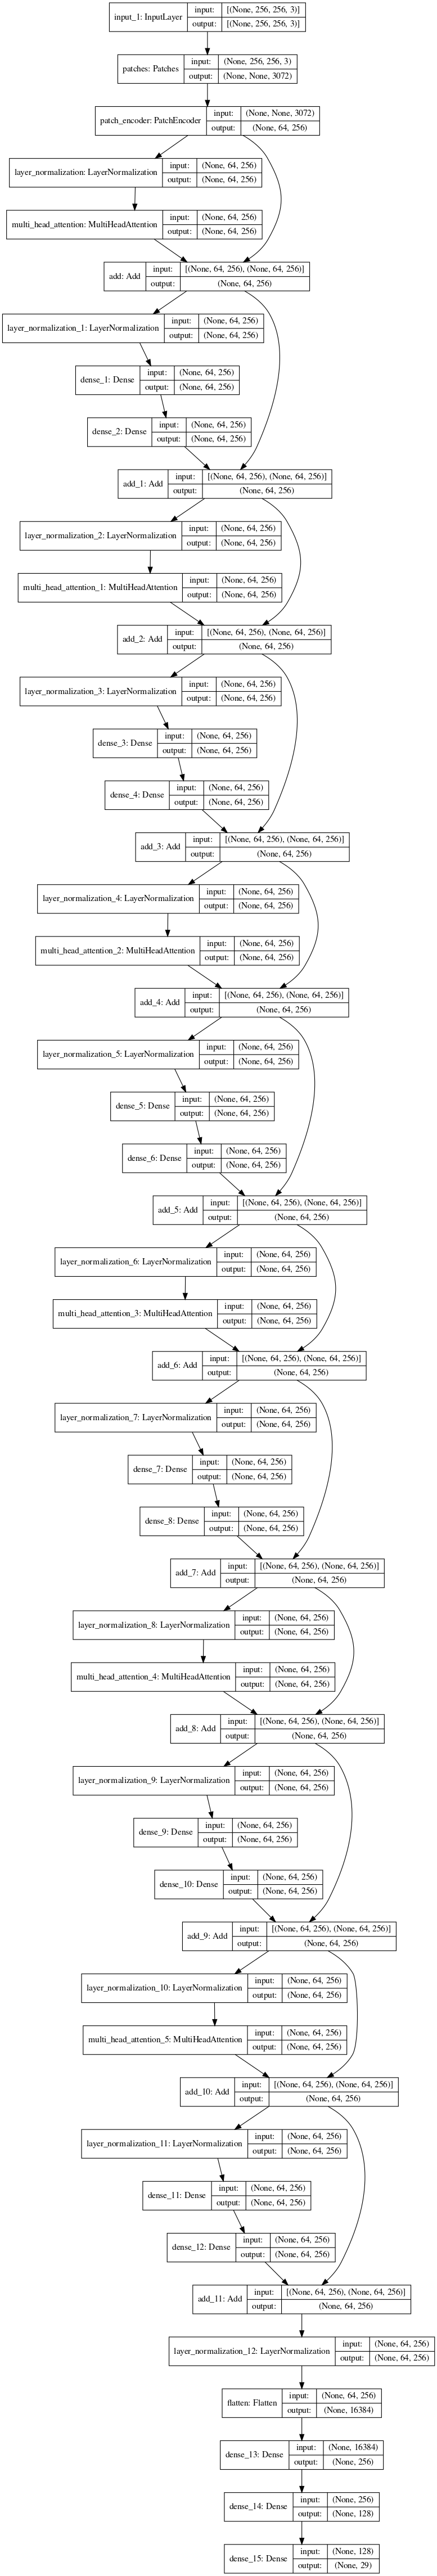

In [14]:
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import plot_model

plot_model(vit_classifier, 
           to_file='vit_classifier.png', 
           show_shapes=True, 
           show_layer_names=True,
           dpi=80,        
           expand_nested=True)


In [ ]:
steps_per_epoch = 85550 // batch_size
decay_steps = steps_per_epoch * 10

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=decay_steps,
    decay_rate=0.96,
    staircase=True
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
)

vit_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = vit_classifier.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose = 1
)

vit_classifier.save_weights('model_weights.h5')

Epoch 1/50
 523/1450 [=========>....................] - ETA: 8:03 - loss: 3.8369 - accuracy: 0.0337

In [ ]:
vit_classifier.save('./vit_classifier')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('accuracy_plot.png', dpi=300)


plt.show()
plt.clf()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss_plot.png', dpi=300)

plt.show()
plt.clf()

In [2]:
#vit_classifier.load_weights('../Project/shell_script/model_weights.h5') 
vit_classifier = tf.keras.models.load_model('./shell_script/vit_classifier')
vit_classifier.load_weights('./shell_script/model_weights.h5') 

In [15]:
image_path = './asl-alphabet/asl_alphabet_test/Q/Q102.jpg'
#image_path = './asl-alphabet/asl_alphabet_train/C/C100.jpg'

img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
img_array /= 255.0  # Rescale like in training

# Make prediction
predictions = vit_classifier.predict(img_array)

# Get the class with highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class names from the train_dataset
class_names = list(train_dataset.class_indices.keys())
predicted_label = class_names[predicted_class]

# Get prediction confidence
confidence = np.max(tf.nn.softmax(predictions)) * 100

print(f"Predicted Sign: {predicted_label}")
print(f"Confidence: {confidence:.2f}%")

Predicted Sign: Q
Confidence: 99.80%


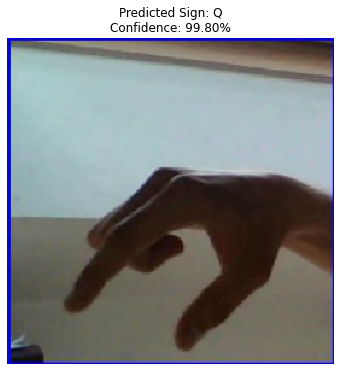

<Figure size 432x288 with 0 Axes>

In [16]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Sign: {predicted_label}\nConfidence: {confidence:.2f}%")

plt.savefig('prediction.png', dpi=300)

plt.show()
plt.clf()

In [10]:
# Calculate steps as before
steps = (test_dataset.samples // test_dataset.batch_size)

predictions = vit_classifier.predict(test_dataset, steps=steps, verbose=1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_dataset.classes

# Drop last incomplete batch from both true_classes and predicted_classes
true_classes = true_classes[:len(predicted_classes)]

assert len(true_classes) == len(predicted_classes), f"Mismatch: {len(true_classes)} vs {len(predicted_classes)}"

report = classification_report(true_classes, predicted_classes, target_names=list(test_dataset.class_indices.keys()))
print("\n",report)

30/30 [==============================] - 3s 91ms/step

               precision    recall  f1-score   support

           A       0.84      0.98      0.91        50
           B       0.91      0.96      0.93        50
           C       1.00      0.92      0.96        50
           D       0.94      0.98      0.96        50
           E       0.94      0.90      0.92        50
           F       0.98      1.00      0.99        50
           G       0.91      0.96      0.93        50
           H       0.96      0.94      0.95        50
           I       0.95      0.84      0.89        50
           J       0.87      0.94      0.90        50
           K       1.00      0.94      0.97        50
           L       1.00      0.94      0.97        50
           M       0.96      0.98      0.97        50
           N       0.98      0.94      0.96        50
           O       0.98      0.96      0.97        50
           P       0.87      0.92      0.89        50
           Q       0.87  

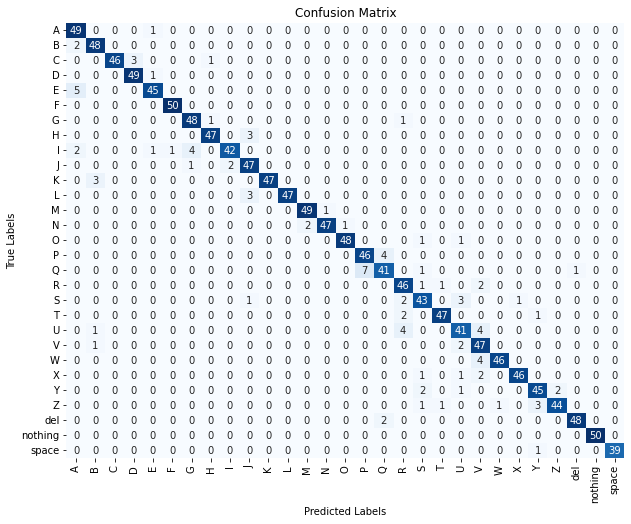

<Figure size 432x288 with 0 Axes>

In [11]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys(),
            cbar=False, annot_kws={"size": 10})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('confusionmatrix.png', dpi=300)

plt.show()
plt.clf()